# <a name="contents">Содержание</a>
## [1. Ознакомление и предобработка данных](#stage_1)
   

## [2. Решение поставленных задач](#stage_2)


## [3. Выводы](#stage_3)

### Описание эксперимента
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом


### Описание колонок
- value – значения метрики
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест)


### Задача
Сравните результат между тестом и контролем по двум кейсам:
- Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
- Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value
- Напишите выводы, которые можно сделать на основе анализа примененных критериев

<a name="stage_1"></a>
# 1. Ознакомление и предобработка данных.


[Наверх к оглавлению](#contents)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(16,8)})

from tqdm.auto import tqdm

In [2]:
path = r'C:\Users\Alex\Karpov\7. Statistics\Lesson_9\hw_bootstrap.csv'
df = pd.read_csv(path, sep=';')
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df.value = df.value.str.replace(',', '.').astype(float)

In [6]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [7]:
Treatment = df[df.experimentVariant == 'Treatment']['value']
Control = df[df.experimentVariant == 'Control']['value']

C:\Users\Alex\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

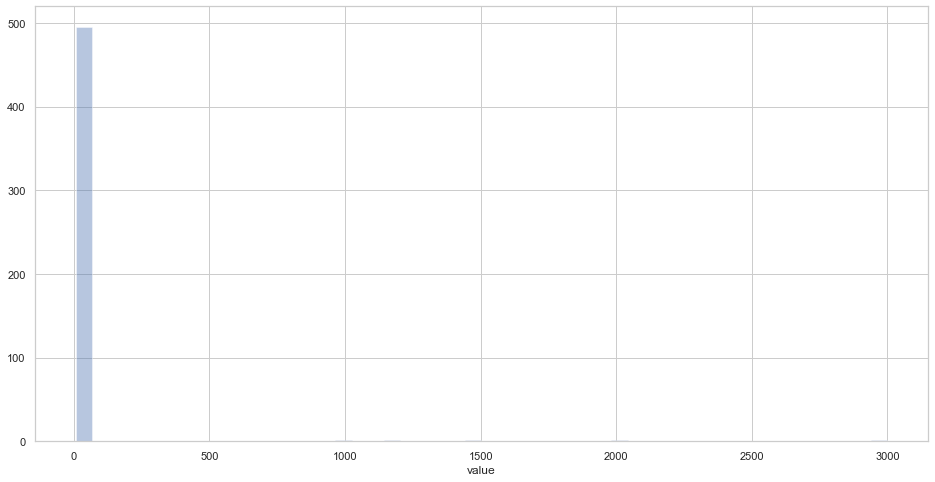

In [8]:
# Посмотрим на распределение значений в тестовой группе
sns.distplot(Treatment, kde=False, bins=50)

In [9]:
# посмотрим на статистику тестовой группы
Treatment.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

<AxesSubplot:xlabel='value'>

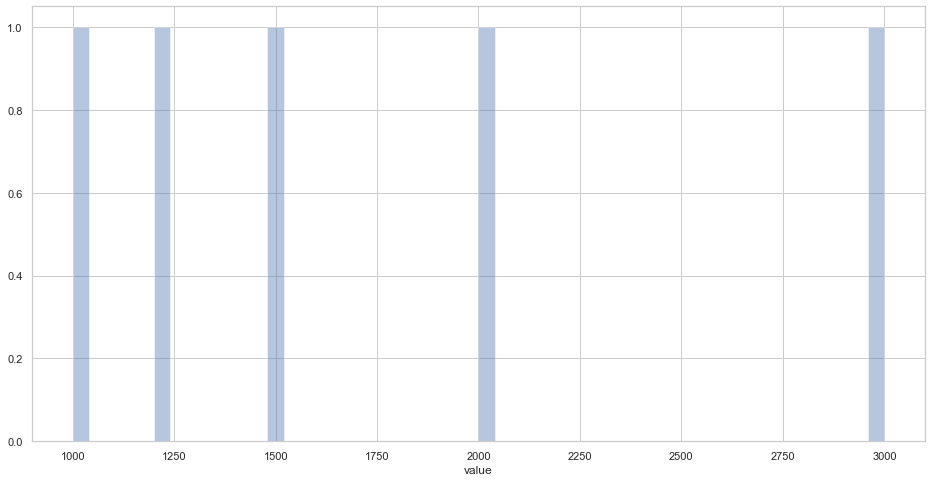

In [10]:
# посмотрим на распределение аномальных выбросов в тестовой группе
sns.distplot(Treatment[Treatment>500], kde=False, bins=50)

<AxesSubplot:xlabel='value'>

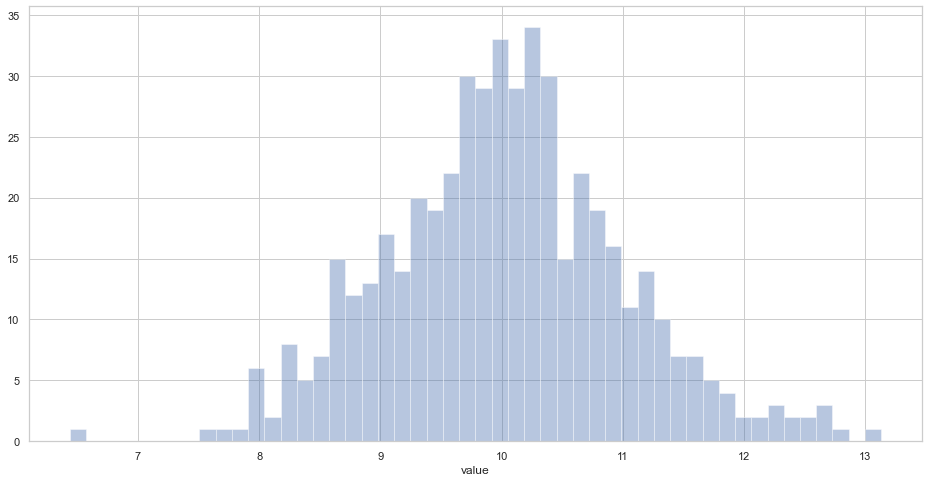

In [11]:
# посмотрим на распределенеи тестовой группы без аномальных выбросов
sns.distplot(Treatment[Treatment<500], kde=False, bins=50)

<AxesSubplot:xlabel='value'>

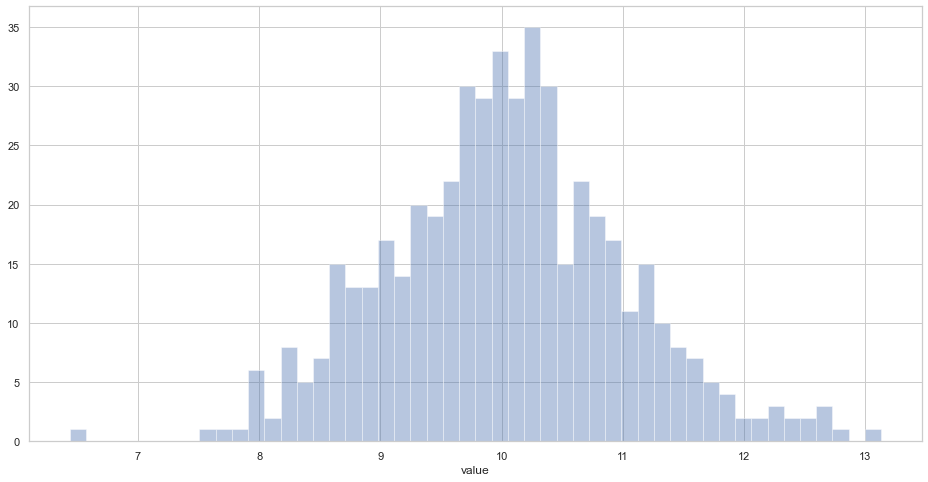

In [12]:
# Посмотрим на распределение значений в контрольной группе
sns.distplot(Control, kde=False, bins=50)

In [13]:
# Вывод: 
# можно заметить, что если отсечить аномальные выбросы тестовой группы,
# наши выборки будут иметь почти идентичное распределение.

<a name="stage_2"></a>
# 2. Решение поставленных задач.


[Наверх к оглавлению](#contents)

### Сравним результаты между двумя группами, используя метод Bootstrap (с np.mean)

In [14]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

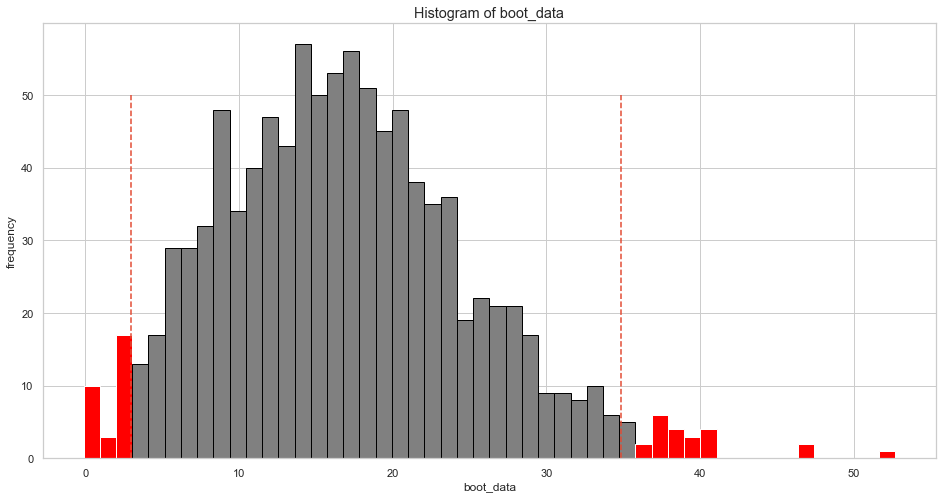

In [15]:
booted_data_mean = get_bootstrap_mean(Treatment, Control)

In [16]:
booted_data_mean["p_value"]

0.03978137224340111

In [17]:
booted_data_mean["quants"]

,0
0.025,2.946721
0.975,34.862769


In [18]:
# Вывод: 
# т.к. 0 не попал в доверительный интервалл [2.96, 34.8],
# делаем вывод, что наши средние значения выборки cтатистически значимо различаются.

### Сравним результаты между двумя группами, используя критерий Mana-Whitney

In [19]:
# Проверим распределения на нормальность

In [20]:
st.shapiro(Treatment)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [21]:
st.shapiro(Control)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

In [22]:
# В обоих случаях значения признака распределены не нормально.

In [23]:
st.mannwhitneyu(Treatment, Control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [24]:
# Вывод: 
# т.к. p-value > 0.05,
# делаем вывод, что мы не смогли найти статистически значимые различия.
# Мы не можем отклонить нулевую гипотезу

### Сравним результаты между двумя группами, используя метод Bootstrap (с np.median)

In [25]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

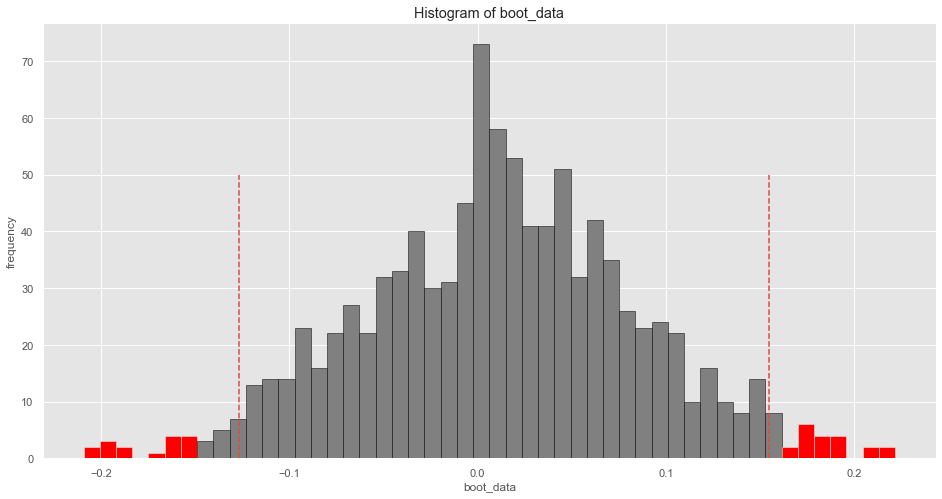

In [26]:
booted_data_median = get_bootstrap_median(Treatment, Control)

In [27]:
booted_data_median["p_value"]

0.8738699217788218

In [28]:
booted_data_median["quants"]

,0
0.025,-0.126548
0.975,0.154732


In [29]:
# Вывод: 
# т.к. 0 попал в доверительный интервалл [-0.13, 0.15],
# делаем вывод, что наши медианные значения выборки cтатистически значимо различаются.

<a name="stage_3"></a>
# 3. Выводы.


[Наверх к оглавлению](#contents)

1. При проверке различий в двух группах используя Bootstrap (с np.mean), мы получили статистически значимые различия (p-value = 0.037). Это произошло потому, что мы сравнивали средние значения, которые подвержены влиянию выбросов.
2. При проверке различий в двух группах используя критерия Мана - Уитни, мы не получили статистически значимые различия (p-value = 0.43). Это произошло потому, что этот критерий использует ранжированние значения признака и аномальные выбросы не смогли повлиять на значение средних.
3. При проверке различий в двух группах используя Bootstrap (с np.median), мы не получили статистически значимые различия (p-value = 0.9). Это произошло потому, что мы сравнивали медианные значения, которые не так сильно подвержены влиянию выбросов.
4. Критерий Мана - Уитни не может проверять различия любых параметров выборки. Он дает нам ответ только о том, есть ли статистически значимые различия или нет.